<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/thermodynamics/Co2_recompression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CO2 recompression and evaluation of chemical reaction in a recompression train

 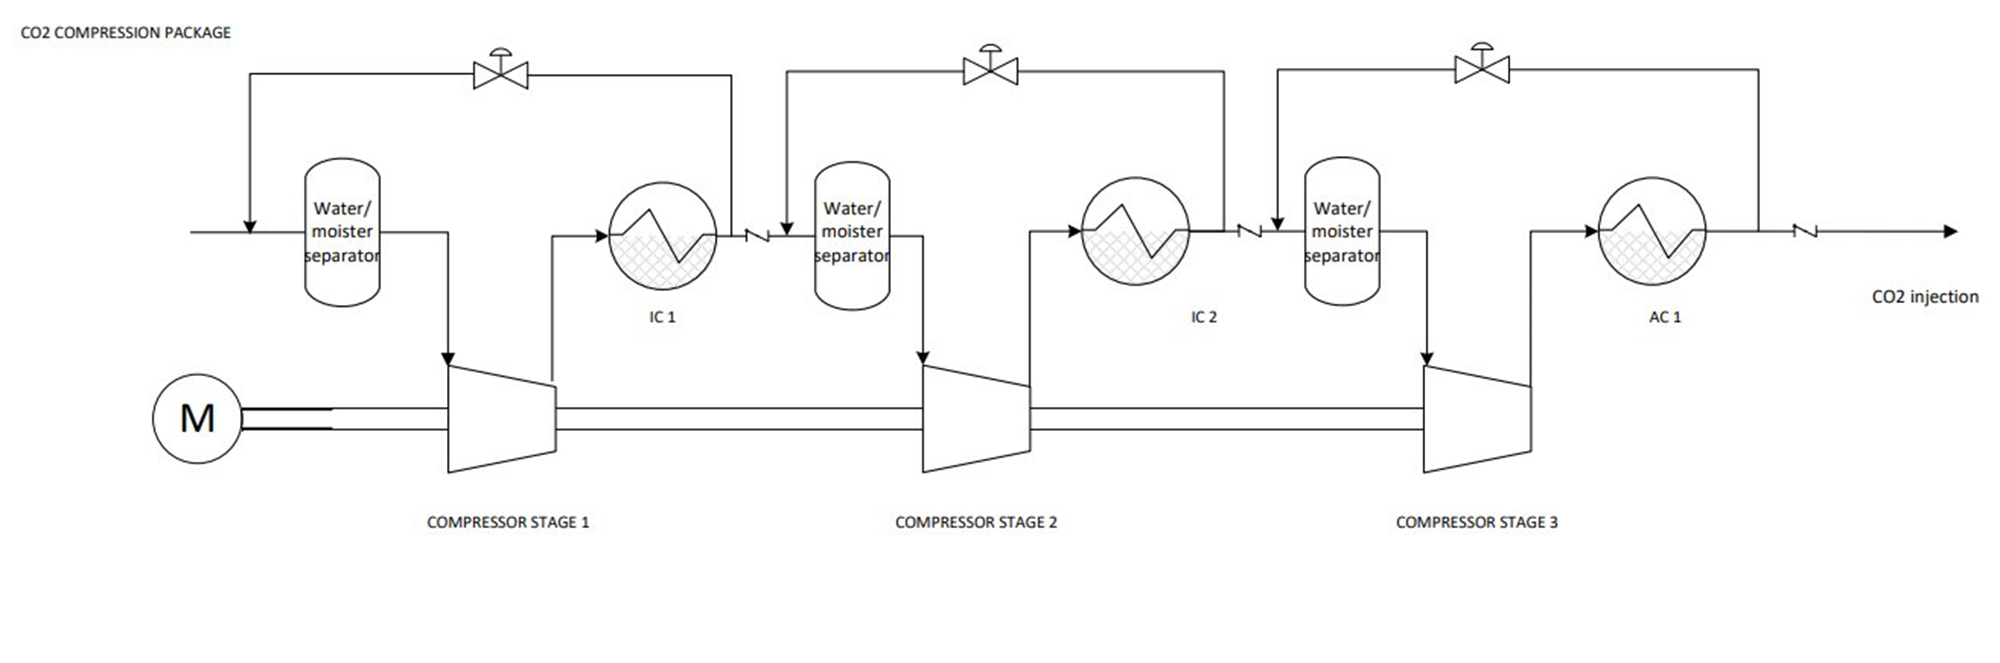

# Introduction

This notebook explores the process of CO2 recompression and evaluates the chemical reaction within a recompression train. The notebook utilizes Python with NeqSim and Reaktoro libraries to simulate and analyze the process.

The notebook covers the following topics:
- Chemical reactions involved in CO2 recompression.
- Modeling and simulation of a recompression train.
- Evaluation of the chemical reaction in the recompression train.

This notebook aims to provide a comprehensive understanding of CO2 recompression and possible simulatanious reactions on gas and aqueous phases.

# Install required libraries and import packages

In [ ]:
%%capture
!pip install neqsim
#https://reaktoro.org/installation/installation-in-google-colab.html
!pip install -q condacolab
import condacolab
condacolab.install_from_url("https://repo.anaconda.com/miniconda/Miniconda3-py38_4.12.0-Linux-x86_64.sh")
!conda config --remove channels defaults
!conda config --add channels conda-forge
!conda install reaktoro -y

In [ ]:
import pandas as pd
import reaktoro as rkt
import json
from neqsim import jneqsim as neqsim
from reaktoro import *
from neqsim.thermo import fluid_df, TPflash, printFrame

# Create NeqSim unit operations using Reaktoro

## Gas phase Reaction NeqSim unit opeation

In [ ]:
from neqsim.process.unitop import unitop
from jpype import JImplements, JOverride

class GasReactor(unitop):
    def __init__(self):
        super().__init__()
        self.serialVersionUID = None
        self.name = None
        self.inletstream = None
        self.outletstream = None

    def setInletStream(self, stream):
        self.inletstream = stream
        self.outletstream = stream.clone()

    def getOutletStream(self):
        return self.outletstream

    def calc_reaktoro(self):
      db = NasaDatabase("nasa-cea")
      gases = GaseousPhase("CO2 H2O H2S SO2 NO2 NO O2 H2 CO CH4 N2 H2SO4 CH3COOH N2O HNO3 NO3 N2O5 NH3 HNO3 S8")
      system = ChemicalSystem(db, gases)

      state = ChemicalState(system)
      state.temperature(self.inletstream.getTemperature("C"), "celsius")
      state.pressure(self.inletstream.getPressure("bara"), "bar")
      state.set("CO2", self.inletstream.getFluid().getComponent("CO2").getNumberOfmoles(), "mol")
      state.set("N2", self.inletstream.getFluid().getComponent("nitrogen").getNumberOfmoles(), "mol")
      state.set("O2", self.inletstream.getFluid().getComponent("oxygen").getNumberOfmoles(), "mol")
      state.set("H2O", self.inletstream.getFluid().getComponent("water").getNumberOfmoles(), "mol")
      state.set("H2S", self.inletstream.getFluid().getComponent("H2S").getNumberOfmoles(), "mol")
      state.set("NO2",  self.inletstream.getFluid().getComponent("NO2").getNumberOfmoles(), "mol")
      state.set("SO2",  self.inletstream.getFluid().getComponent("SO2").getNumberOfmoles(), "mol")
      state.set("NH3",  self.inletstream.getFluid().getComponent("ammonia").getNumberOfmoles(), "mol")
      #print("=== INITIAL STATE ===")
      #print(state)
      solver = EquilibriumSolver(system)
      solver.solve(state)

      CO2_concentration = state.speciesAmount("CO2")
      N2_concentration = state.speciesAmount("N2")
      O2_concentration = state.speciesAmount("O2")
      NO2_concentration = state.speciesAmount("NO2")
      CO_concentration = state.speciesAmount("CO")
      SO2_concentration = state.speciesAmount("SO2")
      H2S_concentration = state.speciesAmount("H2S")
      NH3_concentration = state.speciesAmount("NH3")
      H2SO4_concentration = state.speciesAmount("H2SO4")
      HNO3_concentration = state.speciesAmount("HNO3")
      H2O_concentration = state.speciesAmount("H2O")

      molarrates = [CO2_concentration, N2_concentration, O2_concentration, NO2_concentration, CO_concentration, SO2_concentration, H2S_concentration, NH3_concentration, H2SO4_concentration, HNO3_concentration, H2O_concentration]
      self.outletstream.getFluid().setMolarFlowRates(molarrates)
      self.outletstream.run()

    @JOverride
    def run(self):
      #self.serialVersionUID = uuid
      #print("ReaktoroUnitOperation.run()")
      self.calc_reaktoro()

    @JOverride
    def toJson(self):
      data_dict = {
            "name": self.name
      }
      return json.dumps(data_dict)


## Liquid phase reaction NeqSim unit operation

In [ ]:
class LiquidReactor(unitop):
    def __init__(self):
        super().__init__()
        self.serialVersionUID = None
        self.name = ""
        self.sulfuricacid_weight_percent = ""
        self.nitric_acid_weight_percent = ""
        self.inletstream = None
        self.outletstream = None

    def setInletStream(self, stream):
        self.inletstream = stream
        self.outletstream = stream.clone()

    def getOutletStream(self):
        return self.outletstream

    def getOutletStream(self):
        return self.outletstream

    def calc_reaktoro(self):
      db = PhreeqcDatabase("phreeqc.dat")

      solution = AqueousPhase(speciate("H O C N S"))
      solution.set(ActivityModelPhreeqc(db))

      gases = GaseousPhase("N2(g) CO2(g) H2O(g) H2S(g) O2(g) NH3(g) CH4(g)")
      gases.set(ActivityModelPengRobinsonPhreeqcOriginal())

      minerals = MineralPhases()

      system = ChemicalSystem(db, solution, gases, minerals)

      state = ChemicalState(system)
      state.temperature(self.inletstream.getTemperature("C"), "celsius")
      state.pressure(self.inletstream.getPressure("atm"), "atm")
      state.add("H2O"    , self.inletstream.getFluid().getComponent("water").getFlowRate("kg/sec"), "kg")
      state.add("CO2"    , self.inletstream.getFluid().getComponent("CO2").getFlowRate("mole/sec"), "mol")
      state.add("N2"    , self.inletstream.getFluid().getComponent("nitrogen").getFlowRate("mole/sec"), "mol")
      state.add("O2"    , self.inletstream.getFluid().getComponent("oxygen").getFlowRate("mole/sec"), "mol")
      state.add("H2S"    , self.inletstream.getFluid().getComponent("H2S").getFlowRate("mole/sec"), "mol")

      #H2SO4
      state.add("SO4-2"    , self.inletstream.getFluid().getComponent("sulfuric acid").getFlowRate("mole/sec"), "mol")
      state.set("H+"    , 2*self.inletstream.getFluid().getComponent("sulfuric acid").getFlowRate("mole/sec"), "mol")

      #HNO3
      state.add("NO3-"    , self.inletstream.getFluid().getComponent("nitric acid").getFlowRate("mole/sec"), "mol")
      state.add("H+"    , self.inletstream.getFluid().getComponent("nitric acid").getFlowRate("mole/sec"), "mol")

      #print("=== START STATE ===")
      #print(state)
      equilibrate(state);

      aprops = AqueousProps(state);

      #print(aprops)

      solver = EquilibriumSolver(system);
      solver.solve(state);
      #print("=== FINAL STATE ===")
      #print(state)

      aprops = AqueousProps(state);

      CO2_concentration = state.speciesAmount("CO2(g)")
      N2_concentration = state.speciesAmount("N2(g)")
      NO2_concentration = self.inletstream.getFluid().getComponent("NO2").getFlowRate("mole/sec")
      CO_concentration = self.inletstream.getFluid().getComponent("CO").getFlowRate("mole/sec")
      SO2_concentration = self.inletstream.getFluid().getComponent("SO2").getFlowRate("mole/sec")
      H2O_concentration = state.speciesAmount("H2O(g)")
      O2_concentration = state.speciesAmount("O2(g)")
      H2S_concentration = state.speciesAmount("H2S(g)")
      NH3_concentration = state.speciesAmount("NH3(g)")
      H2O_concentration = state.speciesAmount("H2O(g)")

      molarrates = [CO2_concentration, N2_concentration, O2_concentration, NO2_concentration, CO_concentration, SO2_concentration, H2S_concentration, NH3_concentration, 0, 0, H2O_concentration]
      self.outletstream.getFluid().setMolarFlowRates(molarrates)
      self.outletstream.run()

      molecular_weight_sulfuric_acid = 98.079
      self.sulfuricacid_weight_percent = str(state.speciesAmount("SO4-2")*molecular_weight_sulfuric_acid/(state.speciesAmount("H2O")*18.02/100.0)*100)
      #print('sulfuric acid wt% ', self.sulfuricacid_weight_percent)
      sulfuricacid_molality = state.speciesAmount("SO4-2")/(state.speciesAmount("H2O")*18.02/100.0)
      #print('sullfuricacid_molality ', sulfuricacid_molality)
      molecular_weight_nitric_acid = 63.01
      self.nitric_acid_weight_percent = str(state.speciesAmount("NO3-")*molecular_weight_nitric_acid/(state.speciesAmount("H2O")*18.02/100.0)*100)

    @JOverride
    def run(self):
      #self.serialVersionUID = uuid
      #print("ReaktoroUnitOperation.run()")
      self.calc_reaktoro()

    @JOverride
    def toJson(self):
      data_dict = {
            "name": self.name,
            "sulfuric_acid": self.sulfuricacid_weight_percent,
            "nitric_acid": self.nitric_acid_weight_percent,
      }
      return json.dumps(data_dict)

# Feed fluid definition



 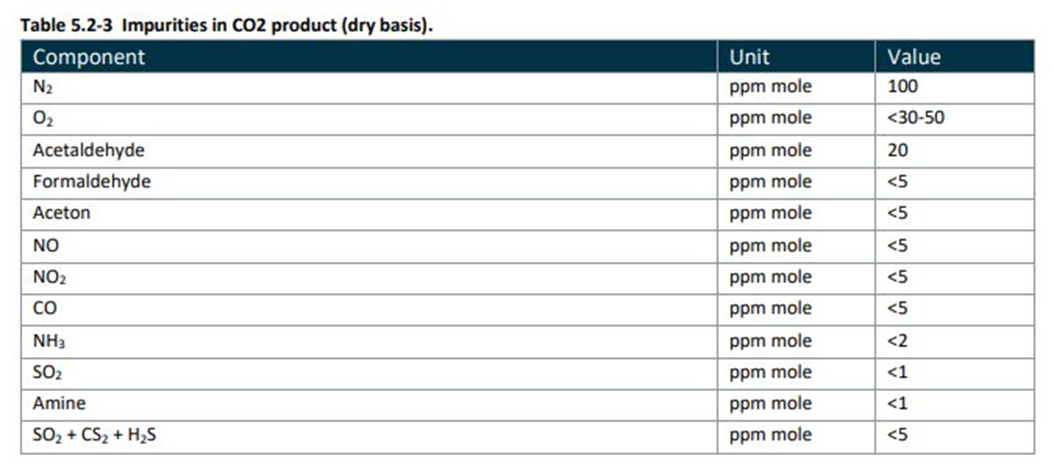

In [ ]:
# Create a gas-condensate fluid
feedfluid = {'ComponentName':  ["CO2", "nitrogen", "oxygen", "NO2", "CO", "SO2", "H2S", "ammonia", "sulfuric acid", "nitric acid", "water"],
        'MolarComposition[-]':  [1.0, 100.0e-6, 30e-6, 5e-6, 5e-6, 1e-6, 5e-6, 1e-6, 0.0, 0.0, 0.0001]
}

feedfluiddf = pd.DataFrame(feedfluid)
print("Natural Gas Fluid:\n")
print(feedfluiddf.head(30).to_string())
feedfluid_neqsim = fluid_df(feedfluiddf,modelName='cpa')
feedfluid_neqsim.setMixingRule(10)

feedfluid_neqsim.setTemperature(30.0, 'C')
feedfluid_neqsim.setPressure(1.2, 'bara')
TPflash(feedfluid_neqsim)
printFrame(feedfluid_neqsim)

Natural Gas Fluid:

    ComponentName  MolarComposition[-]
0             CO2             1.000000
1        nitrogen             0.000100
2          oxygen             0.000030
3             NO2             0.000005
4              CO             0.000005
5             SO2             0.000001
6             H2S             0.000005
7         ammonia             0.000001
8   sulfuric acid             0.000000
9     nitric acid             0.000000
10          water             0.000100
| 0                    | 1          | 2                    | 3   | 4   | 5   | 6               |
|:---------------------|:-----------|:---------------------|:----|:----|:----|:----------------|
|                      | total      | GAS                  |     |     |     |                 |
| CO2                  | 9.99753E-1 | 9.99753E-1           |     |     |     | [mole fraction] |
| nitrogen             | 9.99753E-5 | 9.99753E-5           |     |     |     | [mole fraction] |
| oxygen               | 2.

# Recompression process



In [ ]:
from neqsim.thermo import fluid, TPflash, phaseenvelope, fluid_df
from neqsim.process import stream, compressor, cooler, separator, mixer, valve, pump, clearProcess,saturator

clearProcess()
# Create feed stream
feedStream = stream('feed1 ', feedfluid_neqsim)
feedStream.setTemperature(30.0, "C")
feedStream.setPressure(1.2, "bara")
feedStream.setFlowRate(10.0, "kg/sec")
feedStream.run()

water_saturator = saturator('water saturator', feedStream)
water_saturator.run()

gasreacot1 = GasReactor()
gasreacot1.setName('gas reactor 1')
gasreacot1.setInletStream(water_saturator.getOutStream())
gasreacot1.run()

# Create compressor
compressor1 = compressor(' compressor 1', gasreacot1.getOutletStream())
compressor1.setOutletPressure(5.4, "bara")
compressor1.setIsentropicEfficiency(0.8)
compressor1.run()

# Create cooler
cooler1 = cooler('cooler 1', compressor1.getOutStream())
cooler1.setOutTemperature(25.0, "C")
cooler1.run()

liqreactor = LiquidReactor()
liqreactor.setName('liquid reactor 1')
liqreactor.setInletStream(cooler1.getOutStream())
liqreactor.run()

# Create separator
separator1 = separator('sep 1', liqreactor.getOutletStream())

gasreacot2 = GasReactor()
gasreacot2.setName('gas reactor 2')
gasreacot2.setInletStream(separator1.getGasOutStream())
gasreacot2.run()

# Create compressor
compressor2 = compressor(' compressor 2', gasreacot2.getOutletStream())
compressor2.setOutletPressure(18.0, "bara")
compressor2.setIsentropicEfficiency(0.8)
compressor2.run()

# Create cooler
cooler2 = cooler('cooler 2', compressor2.getOutStream())
cooler2.setOutTemperature(25.0, "C")
cooler2.run()

liqreactor2 = LiquidReactor()
liqreactor2.setName('liquid reactor 2')
liqreactor2.setInletStream(cooler2.getOutStream())
liqreactor2.run()

# Create separator
separator2 = separator('sep 2', liqreactor2.getOutletStream())

gasreacot3 = GasReactor()
gasreacot3.setName('gas reactor 3')
gasreacot3.setInletStream(separator2.getGasOutStream())
gasreacot3.run()

# Create compressor
compressor3 = compressor(' compressor 3', gasreacot3.getOutletStream())
compressor3.setOutletPressure(65.0, "bara")
compressor3.setIsentropicEfficiency(0.8)
compressor3.run()

# Create cooler
cooler3 = cooler('cooler 3', compressor3.getOutStream())
cooler3.setOutTemperature(25.0, "C")
cooler3.run()

liqreactor3 = LiquidReactor()
liqreactor3.setName('liquid reactor 3')
liqreactor3.setInletStream(cooler3.getOutStream())
liqreactor3.run()

# Create separator
separator3 = separator('sep 3', liqreactor3.getOutletStream())

co2_process = neqsim.process.processmodel.ProcessSystem()
co2_process.add(feedStream)
co2_process.add(water_saturator)
co2_process.add(gasreacot1)
co2_process.add(compressor1)
co2_process.add(cooler1)
co2_process.add(liqreactor)
co2_process.add(separator1)
co2_process.add(gasreacot2)
co2_process.add(compressor2)
co2_process.add(cooler2)
co2_process.add(liqreactor2)
co2_process.add(separator2)
co2_process.add(gasreacot3)
co2_process.add(compressor3)
co2_process.add(cooler3)
co2_process.add(liqreactor3)
co2_process.add(separator3)
co2_process.run()

# Results

wt% of acids in water from separators:

In [34]:
liqreactor.toJson()

'{"name": "liquid reactor 1", "sulfuric_acid": "68.865", "nitric_acid": "3.20037e-05"}'

In [35]:
liqreactor2.toJson()

'{"name": "liquid reactor 2", "sulfuric_acid": "3.90408e-09", "nitric_acid": "0.190165"}'

In [36]:
liqreactor3.toJson()

'{"name": "liquid reactor 3", "sulfuric_acid": "8.69503e-11", "nitric_acid": "1.07985"}'

## Feed gas

In [37]:
printFrame(water_saturator.getOutStream().getFluid())

| 0                    | 1          | 2                    | 3   | 4   | 5   | 6               |
|:---------------------|:-----------|:---------------------|:----|:----|:----|:----------------|
|                      | total      | GAS                  |     |     |     |                 |
| CO2                  | 9.63912E-1 | 9.63912E-1           |     |     |     | [mole fraction] |
| nitrogen             | 9.63912E-5 | 9.63912E-5           |     |     |     | [mole fraction] |
| oxygen               | 2.89174E-5 | 2.89174E-5           |     |     |     | [mole fraction] |
| NO2                  | 4.81956E-6 | 4.81956E-6           |     |     |     | [mole fraction] |
| CO                   | 4.81956E-6 | 4.81956E-6           |     |     |     | [mole fraction] |
| SO2                  | 9.63912E-7 | 9.63912E-7           |     |     |     | [mole fraction] |
| H2S                  | 4.81956E-6 | 4.81956E-6           |     |     |     | [mole fraction] |
| ammonia              | 9.639

## Reacted feed gas

In [38]:
printFrame(gasreacot1.getOutletStream().getFluid())

| 0                    | 1           | 2                    | 3   | 4   | 5   | 6               |
|:---------------------|:------------|:---------------------|:----|:----|:----|:----------------|
|                      | total       | GAS                  |     |     |     |                 |
| CO2                  | 9.63925E-1  | 9.63925E-1           |     |     |     | [mole fraction] |
| nitrogen             | 9.92842E-5  | 9.92842E-5           |     |     |     | [mole fraction] |
| oxygen               | 2.28932E-5  | 2.28932E-5           |     |     |     | [mole fraction] |
| NO2                  | 2.14414E-16 | 2.14414E-16          |     |     |     | [mole fraction] |
| CO                   | 4.24283E-19 | 4.24283E-19          |     |     |     | [mole fraction] |
| SO2                  | 4.24283E-19 | 4.24283E-19          |     |     |     | [mole fraction] |
| H2S                  | 4.24283E-19 | 4.24283E-19          |     |     |     | [mole fraction] |
| ammonia           

## Injection CO2

In [39]:
printFrame(separator3.getGasOutStream().getFluid())

| 0                    | 1          | 2                    | 3   | 4   | 5   | 6               |
|:---------------------|:-----------|:---------------------|:----|:----|:----|:----------------|
|                      | total      | GAS                  |     |     |     |                 |
| CO2                  | 9.97745E-1 | 9.97745E-1           |     |     |     | [mole fraction] |
| nitrogen             | 9.97859E-5 | 9.97859E-5           |     |     |     | [mole fraction] |
| oxygen               | 2.99357E-5 | 2.99357E-5           |     |     |     | [mole fraction] |
| NO2                  | 4.96211E-6 | 4.96211E-6           |     |     |     | [mole fraction] |
| CO                   | 4.9893E-6  | 4.9893E-6            |     |     |     | [mole fraction] |
| SO2                  | 9.97228E-7 | 9.97228E-7           |     |     |     | [mole fraction] |
| H2S                  | 4.98758E-6 | 4.98758E-6           |     |     |     | [mole fraction] |
| ammonia              | 4.927

# Same recompression process, but no chemical reactions

In the following example we will run the same calculations, but in this case we will not consider reactions to happen in gas and water phase.

In [40]:
from neqsim.thermo import fluid, TPflash, phaseenvelope, fluid_df
from neqsim.process import stream, compressor, cooler, separator, mixer, valve, pump, clearProcess,saturator

clearProcess()
# Create feed stream
feedStream = stream('feed1 ', feedfluid_neqsim)
feedStream.setTemperature(30.0, "C")
feedStream.setPressure(1.2, "bara")
feedStream.setFlowRate(10.0, "kg/sec")
feedStream.run()

water_saturator = saturator('water saturator', feedStream)
water_saturator.run()

# Create compressor
compressor1 = compressor(' compressor 1', water_saturator.getOutletStream())
compressor1.setOutletPressure(5.4, "bara")
compressor1.setIsentropicEfficiency(0.8)
compressor1.run()

# Create cooler
cooler1 = cooler('cooler 1', compressor1.getOutStream())
cooler1.setOutTemperature(25.0, "C")
cooler1.run()

# Create separator
separator1 = separator('sep 1', cooler1.getOutletStream())

# Create compressor
compressor2 = compressor('compressor 2', separator1.getGasOutStream())
compressor2.setOutletPressure(18.0, "bara")
compressor2.setIsentropicEfficiency(0.8)
compressor2.run()

# Create cooler
cooler2 = cooler('cooler 2', compressor2.getOutStream())
cooler2.setOutTemperature(25.0, "C")
cooler2.run()

# Create separator
separator2 = separator('sep 2', cooler2.getOutletStream())

# Create compressor
compressor3 = compressor(' compressor 3', separator2.getGasOutStream())
compressor3.setOutletPressure(65.0, "bara")
compressor3.setIsentropicEfficiency(0.8)
compressor3.run()

# Create cooler
cooler3 = cooler('cooler 3', compressor3.getOutStream())
cooler3.setOutTemperature(25.0, "C")
cooler3.run()

# Create separator
separator3 = separator('sep 3', cooler3.getOutletStream())

co2_process = neqsim.process.processmodel.ProcessSystem()
co2_process.add(feedStream)
co2_process.add(water_saturator)
co2_process.add(compressor1)
co2_process.add(cooler1)
co2_process.add(separator1)
co2_process.add(compressor2)
co2_process.add(cooler2)
co2_process.add(separator2)
co2_process.add(compressor3)
co2_process.add(cooler3)
co2_process.add(separator3)
co2_process.run()

In [41]:
printFrame(separator3.getGasOutStream().getFluid())

| 0                    | 1          | 2                    | 3   | 4   | 5   | 6               |
|:---------------------|:-----------|:---------------------|:----|:----|:----|:----------------|
|                      | total      | GAS                  |     |     |     |                 |
| CO2                  | 9.97745E-1 | 9.97745E-1           |     |     |     | [mole fraction] |
| nitrogen             | 9.97859E-5 | 9.97859E-5           |     |     |     | [mole fraction] |
| oxygen               | 2.99357E-5 | 2.99357E-5           |     |     |     | [mole fraction] |
| NO2                  | 4.96211E-6 | 4.96211E-6           |     |     |     | [mole fraction] |
| CO                   | 4.9893E-6  | 4.9893E-6            |     |     |     | [mole fraction] |
| SO2                  | 9.97228E-7 | 9.97228E-7           |     |     |     | [mole fraction] |
| H2S                  | 4.98758E-6 | 4.98758E-6           |     |     |     | [mole fraction] |
| ammonia              | 4.927

Lets assume reactions happens in the pipeline. We will check for possible condesation of water and acids. We will then cool to sea bed temperature and check for condensation.

In [42]:
gasreacot_pipeline = GasReactor()
gasreacot_pipeline.setName('gas reactor pipeline')
gasreacot_pipeline.setInletStream(separator3.getGasOutStream())
gasreacot_pipeline.run()

printFrame(gasreacot_pipeline.getOutletStream().getFluid())

| 0                    | 1           | 2                    | 3   | 4   | 5   | 6               |
|:---------------------|:------------|:---------------------|:----|:----|:----|:----------------|
|                      | total       | GAS                  |     |     |     |                 |
| CO2                  | 9.97758E-1  | 9.97758E-1           |     |     |     | [mole fraction] |
| nitrogen             | 1.02515E-4  | 1.02515E-4           |     |     |     | [mole fraction] |
| oxygen               | 2.40548E-5  | 2.40548E-5           |     |     |     | [mole fraction] |
| NO2                  | 1.34219E-15 | 1.34219E-15          |     |     |     | [mole fraction] |
| CO                   | 4.39227E-19 | 4.39227E-19          |     |     |     | [mole fraction] |
| SO2                  | 4.39227E-19 | 4.39227E-19          |     |     |     | [mole fraction] |
| H2S                  | 4.39227E-19 | 4.39227E-19          |     |     |     | [mole fraction] |
| ammonia           

In [43]:
seacooler = cooler('sea cooler', gasreacot_pipeline.getOutletStream())
seacooler.setOutTemperature(4.0, 'C')
seacooler.run()

printFrame(seacooler.getOutStream().getFluid())

| 0                    | 1           | 2                    | 3   | 4   | 5   | 6               |
|:---------------------|:------------|:---------------------|:----|:----|:----|:----------------|
|                      | total       | GAS                  |     |     |     |                 |
| CO2                  | 9.97758E-1  | 9.97758E-1           |     |     |     | [mole fraction] |
| nitrogen             | 1.02515E-4  | 1.02515E-4           |     |     |     | [mole fraction] |
| oxygen               | 2.40548E-5  | 2.40548E-5           |     |     |     | [mole fraction] |
| NO2                  | 1.34219E-15 | 1.34219E-15          |     |     |     | [mole fraction] |
| CO                   | 4.39227E-19 | 4.39227E-19          |     |     |     | [mole fraction] |
| SO2                  | 4.39227E-19 | 4.39227E-19          |     |     |     | [mole fraction] |
| H2S                  | 4.39227E-19 | 4.39227E-19          |     |     |     | [mole fraction] |
| ammonia           